In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# For the models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM
from sklearn.svm import SVC

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


ModuleNotFoundError: No module named 'distutils'

# Load and Preprocess

In [4]:
import pandas as pd
import numpy as np
# Load datasets
anomaly_df = pd.read_csv("C:/Users/HP/Desktop/new/data/anomaliousTraffic.csv")
normal_df = pd.read_csv("C:/Users/HP/Desktop/new/data/normalTraffic.csv")
web_traffic_df = pd.read_csv("C:/Users/HP/Desktop/new/data/web_traffic.csv")


# Combine datasets
web_df = pd.concat([anomaly_df, normal_df, web_traffic_df], ignore_index=True)

# Handle missing values
web_df.fillna(0, inplace=True)

# Convert contentLength to numeric
web_df['contentLength'] = pd.to_numeric(web_df['contentLength'], errors='coerce')
web_df.fillna(0, inplace=True)  # Fill NaNs after conversion

# Define features and target
features = ['method', 'url', 'protocol', 'userAgent', 'pragma', 'cacheControl', 'accept', 
            'acceptEncoding', 'acceptCharset', 'acceptLanguage', 'host', 'connection', 
            'contentLength', 'payload']
target = 'label'

# Convert target variable to numeric
label_encoder = LabelEncoder()
web_df[target] = label_encoder.fit_transform(web_df[target])

# Split the dataset into features (X) and target (y)
X = web_df[features]
y = web_df[target]

# Encode categorical variables
categorical_cols = ['method', 'url', 'protocol', 'userAgent', 'pragma', 'cacheControl', 
                    'accept', 'acceptEncoding', 'acceptCharset', 'acceptLanguage', 
                    'host', 'connection', 'payload']

# Label encode categorical features
for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

# Scale the numerical data
scaler = StandardScaler()
X['contentLength'] = scaler.fit_transform(X[['contentLength']])

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



C:\Users\HP\AppData\Local\Temp\ipykernel_4272\1751758467.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  anomaly_df = pd.read_csv("C:/Users/HP/Desktop/new/data/anomaliousTraffic.csv")
C:\Users\HP\AppData\Local\Temp\ipykernel_4272\1751758467.py:5: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  normal_df = pd.read_csv("C:/Users/HP/Desktop/new/data/normalTraffic.csv")
C:\Users\HP\AppData\Local\Temp\ipykernel_4272\1751758467.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  web_traffic_df = pd.read_csv("C:/Users/HP/Desktop/new/data/web_traffic.csv")


#  Reshape Data for CNN and LSTM

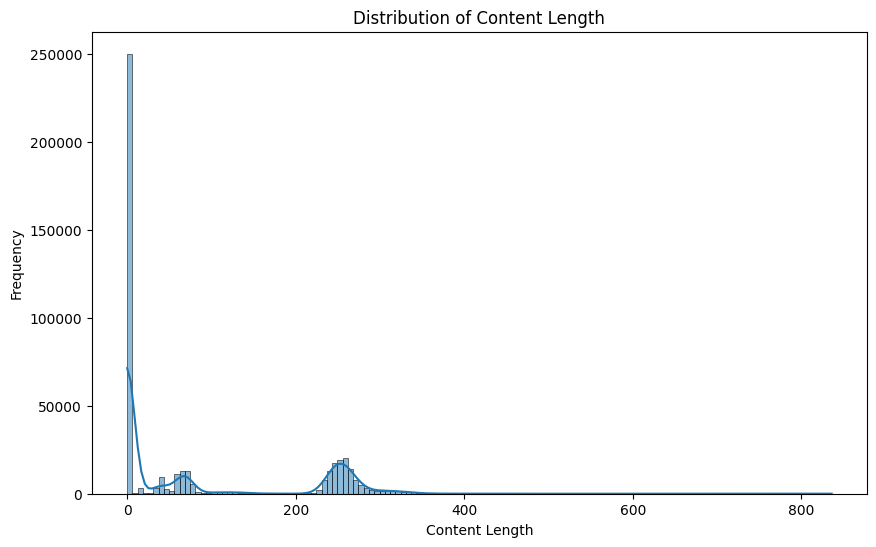

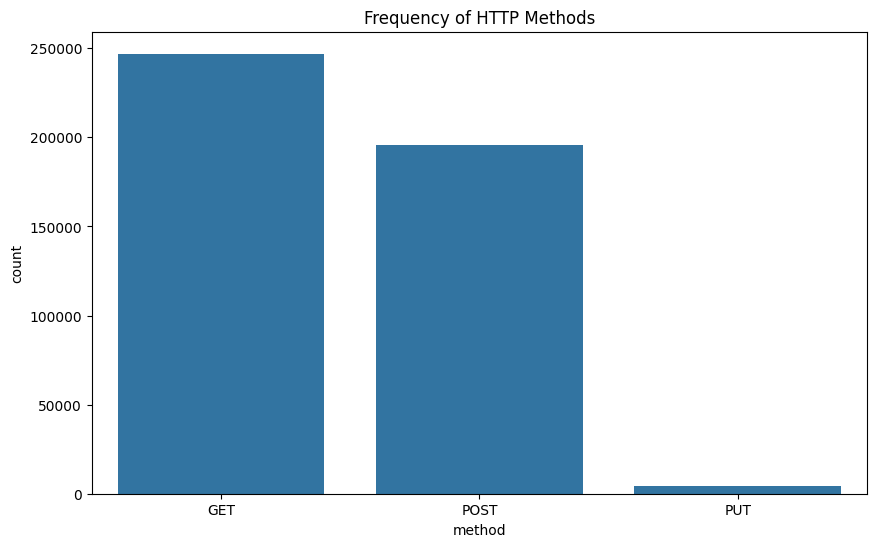

In [5]:
# EDA - Visualizing the Distribution of Content Length
plt.figure(figsize=(10, 6))
sns.histplot(web_df['contentLength'], kde=True)
plt.title('Distribution of Content Length')
plt.xlabel('Content Length')
plt.ylabel('Frequency')
plt.show()

# EDA - Visualizing HTTP Methods
plt.figure(figsize=(10, 6))
sns.countplot(x='method', data=web_df)
plt.title('Frequency of HTTP Methods')
plt.show()


In [ ]:
# Reshape data to 3D for CNN and LSTM
X_train_reshaped = np.expand_dims(X_train, axis=2)
X_test_reshaped = np.expand_dims(X_test, axis=2)


# CNN for Feature Extraction

In [ ]:
# Define CNN model for feature extraction
cnn_model = Sequential()

# Add Conv1D layer
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())

# Output the learned features (dense layer)
cnn_model.add(Dense(64, activation='relu'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Extract CNN features for both training and test sets
X_train_cnn_features = cnn_model.predict(X_train_reshaped)
X_test_cnn_features = cnn_model.predict(X_test_reshaped)


# LSTM for Temporal Dependencies

In [ ]:
# Define LSTM model for temporal pattern recognition
lstm_model = Sequential()

# Add LSTM layers
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_cnn_features.shape[1], 1)))
lstm_model.add(LSTM(units=50))

# Add a Dense layer for output
lstm_model.add(Dense(64, activation='relu'))

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape CNN features for LSTM
X_train_lstm_input = np.expand_dims(X_train_cnn_features, axis=2)
X_test_lstm_input = np.expand_dims(X_test_cnn_features, axis=2)

# Train the LSTM model
lstm_model.fit(X_train_lstm_input, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Extract LSTM features
X_train_lstm_features = lstm_model.predict(X_train_lstm_input)
X_test_lstm_features = lstm_model.predict(X_test_lstm_input)


# SVM for Final Classification

In [ ]:
# Initialize SVM model
svm_model = SVC(kernel='rbf', C=1, gamma=0.1)

# Train the SVM model on LSTM features
svm_model.fit(X_train_lstm_features, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test_lstm_features)


# Model Evaluation

In [ ]:
# Accuracy score
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
print(conf_matrix)

# Visualizing the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomalous'], yticklabels=['Normal', 'Anomalous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


# Hyperparameter Tuning for SVM

In [ ]:
# Hyperparameter tuning for SVM using GridSearchCV
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid_search.fit(X_train_lstm_features, y_train)

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Train with best parameters
best_svm_model = grid_search.best_estimator_

# Predict with the best model
y_pred_best_svm = best_svm_model.predict(X_test_lstm_features)

# Evaluate the best SVM model
print("Optimized SVM Classification Report:")
print(classification_report(y_test, y_pred_best_svm))


In [6]:
# Define categorical and numeric features
categorical_features = ['method', 'url', 'protocol', 'userAgent', 
                        'pragma', 'cacheControl', 'accept', 
                        'acceptEncoding', 'acceptCharset', 
                        'acceptLanguage', 'host', 'connection', 'payload']
numerical_features = ['contentLength']

# Create a column transformer to handle both types of features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),  # Pass through numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode categorical features
    ]
)

# Preprocess features and split data
X = web_df[features]
y = web_df[target]

# Transform the features
X_transformed = preprocessor.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)


TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['int', 'str']

# Model Implementation

# CNN Model

In [ ]:
# Define CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# LSTM Model